In [ ]:
from google.colab import drive
import os

# 將Google Drive掛載到Colab
drive.mount('/content/drive')

# 設定路徑
previous_path = '/content/drive/My Drive/GAN/3d_ts_data/previous'
current_path = '/content/drive/My Drive/GAN/3d_ts_data/current'
next_path = '/content/drive/My Drive/GAN/3d_ts_data/next'

Mounted at /content/drive


In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from PIL import Image
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, previous_path, current_path, next_path, transform=None):
        self.previous_path = previous_path
        self.current_path = current_path
        self.next_path = next_path
        self.previous_folders = sorted(os.listdir(previous_path))
        self.current_folders = sorted(os.listdir(current_path))
        self.next_folders = sorted(os.listdir(next_path))

        self.transform = transform

    def __len__(self):
        return len(self.previous_folders)

    def __getitem__(self, idx):
        previous_folder = self.previous_folders[idx]
        current_folder = self.current_folders[idx]
        next_folder = self.next_folders[idx]

        previous_folder_path = os.path.join(self.previous_path, previous_folder)
        current_folder_path = os.path.join(self.current_path, current_folder)
        next_folder_path = os.path.join(self.next_path, next_folder)

        previous_images = []
        current_images = []
        next_images = []

        previous_image_names = sorted(os.listdir(previous_folder_path))
        current_image_names = sorted(os.listdir(current_folder_path))
        next_image_names = sorted(os.listdir(next_folder_path))

        # 獲取資料夾名稱
        folder_name = os.path.basename(previous_folder_path)

        for image_name in previous_image_names:
            image_path = os.path.join(previous_folder_path, image_name)
            image = Image.open(image_path).convert('L')
            previous_images.append(image)

        previous_stack = np.concatenate([np.array(img) for img in previous_images], axis=1)
        previous_stack = Image.fromarray(previous_stack)

        for image_name in current_image_names:
            image_path = os.path.join(current_folder_path, image_name)
            image = Image.open(image_path).convert('L')
            current_images.append(image)

        current_stack = np.concatenate([np.array(img) for img in current_images], axis=1)
        current_stack = Image.fromarray(current_stack)

        for image_name in next_image_names:
            image_path = os.path.join(next_folder_path, image_name)
            image = Image.open(image_path).convert('L')
            next_images.append(image)

        next_stack = np.concatenate([np.array(img) for img in next_images], axis=1)
        next_stack = Image.fromarray(next_stack)

        if self.transform:
            previous_stack = self.transform(previous_stack)
            current_stack = self.transform(current_stack)
            next_stack = self.transform(next_stack)

        return previous_stack, current_stack, next_stack, folder_name

資料夾名稱: A00001_1


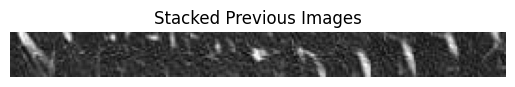

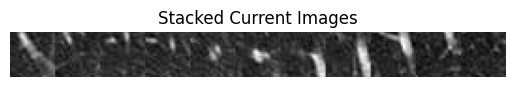

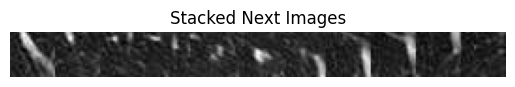

In [ ]:
import matplotlib.pyplot as plt

dataset = CustomDataset(previous_path, current_path, next_path, transform=ToTensor())

index = 0

previous_stack, current_stack, next_stack, folder_name = dataset[index]

print(f"資料夾名稱: {folder_name}")

plt.imshow(previous_stack.squeeze(), cmap='gray')
plt.axis('off')
plt.title('Stacked Previous Images')
plt.show()

plt.imshow(current_stack.squeeze(), cmap='gray')
plt.axis('off')
plt.title('Stacked Current Images')
plt.show()

plt.imshow(next_stack.squeeze(), cmap='gray')
plt.axis('off')
plt.title('Stacked Next Images')
plt.show()

In [ ]:
import torch.nn as nn
import torch.optim as optim

# 定義生成器
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(2, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 1, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, previous_image, current_image):
        x = torch.cat([previous_image, current_image], dim=1)
        generated_image = self.model(x)
        return generated_image

# 定義判別器
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, 3, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, image):
        validity = self.model(image)
        return validity

In [ ]:
from torch.utils.data import DataLoader

# 超參數設定
batch_size = 1
num_epochs = 2000
lr = 0.0002

# 建立資料載入器
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 初始化生成器和判別器
generator = Generator()
discriminator = Discriminator()

# 定義損失函數和優化器
adversarial_loss = nn.BCELoss()
generator_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# 將模型移動到設備上
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = generator.to(device)
discriminator = discriminator.to(device)

In [ ]:
import torchvision.utils as vutils

# 訓練迴圈
for epoch in range(num_epochs):
    for i, (previous_images, current_images, next_images, folder_name) in enumerate(data_loader):
        # 將圖像移動到設備上
        previous_images = previous_images.to(device)
        current_images = current_images.to(device)
        next_images = next_images.to(device)

        # 訓練生成器
        generator_optimizer.zero_grad()

        # 生成假圖像
        generated_images = generator(previous_images, current_images)

        # 計算生成器的損失
        generator_loss = adversarial_loss(discriminator(generated_images), torch.ones_like(generated_images))

        # 更新生成器的參數
        generator_loss.backward()
        generator_optimizer.step()

        # 訓練判別器
        discriminator_optimizer.zero_grad()

        # 計算真實圖像和生成圖像的損失
        real_loss = adversarial_loss(discriminator(next_images), torch.ones_like(next_images))
        fake_loss = adversarial_loss(discriminator(generated_images.detach()), torch.zeros_like(generated_images))
        discriminator_loss = (real_loss + fake_loss) / 2

        # 更新判別器的參數
        discriminator_loss.backward()
        discriminator_optimizer.step()

    if (epoch == 0) or ((epoch + 1) % 100 == 0):
        print(f"Epoch [{epoch+1}/{num_epochs}], Generator Loss: {generator_loss.item():.4f}, Discriminator Loss: {discriminator_loss.item():.4f}")

        generator.train()

Epoch [1/2000], Generator Loss: 0.6728, Discriminator Loss: 0.6819
Epoch [100/2000], Generator Loss: 0.8569, Discriminator Loss: 0.6815
Epoch [200/2000], Generator Loss: 0.7187, Discriminator Loss: 0.6657
Epoch [300/2000], Generator Loss: 0.7960, Discriminator Loss: 0.6168
Epoch [400/2000], Generator Loss: 0.6725, Discriminator Loss: 0.6892
Epoch [500/2000], Generator Loss: 0.8021, Discriminator Loss: 0.6669
Epoch [600/2000], Generator Loss: 0.6569, Discriminator Loss: 0.7009
Epoch [700/2000], Generator Loss: 0.7900, Discriminator Loss: 0.6818
Epoch [800/2000], Generator Loss: 0.8199, Discriminator Loss: 0.6929
Epoch [900/2000], Generator Loss: 0.7363, Discriminator Loss: 0.6685
Epoch [1000/2000], Generator Loss: 0.7615, Discriminator Loss: 0.6504
Epoch [1100/2000], Generator Loss: 0.7213, Discriminator Loss: 0.6326
Epoch [1200/2000], Generator Loss: 0.7703, Discriminator Loss: 0.6819
Epoch [1300/2000], Generator Loss: 0.8436, Discriminator Loss: 0.6775
Epoch [1400/2000], Generator Los

In [ ]:
# 生成影像(3D)

save_path = '/content/drive/My Drive/GAN/save/3D'
os.makedirs(save_path, exist_ok=True)

generator.eval()  # 切換生成器到評估模式

for index, (previous_images, current_images, _, folder_name) in enumerate(data_loader):
    previous_images = previous_images.to(device)
    current_images = current_images.to(device)

    # 生成並裁剪
    generated_images = generator(previous_images, current_images)
    generated_images = generated_images[:, :, :, 120:144]

    # 使用資料夾的名稱作為圖片的名稱，刪除括號和逗號
    folder_name = folder_name[0].replace('(', '').replace(')', '').replace(',', '')
    # print(folder_name)
    image_name = f'{folder_name}.png'

    image_path = os.path.join(save_path, image_name)
    vutils.save_image(generated_images.squeeze().cpu().detach(), image_path)

generator.train()  # 恢復生成器到訓練模式

print("生成並保存完成")

生成並保存完成


In [ ]:
"""
# 真實影像
import torchvision.utils as vutils



save_path = '/content/drive/My Drive/GAN/save/Real'
os.makedirs(save_path, exist_ok=True)

for index in range(len(dataset)):
    previous_stack, current_stack, next_stack, folder_name = dataset[index]

    # 取得圖像
    next_images = next_stack.squeeze()

    # 裁剪圖像以保留最中間的24x24像素
    cropped_images = next_images[ :, 120:144]

    # 使用資料夾的名稱作為圖片的名稱
    print(folder_name)
    image_name = f'{folder_name}.png'
    image_path = os.path.join(save_path, image_name)
    vutils.save_image(cropped_images, image_path)

print("保存完成")
"""